# Post-Processing

In [1]:
%load_ext autoreload
%autoreload 2

::: {.content-hidden}
Import necessary Python modules
:::

In [2]:
import os
import sys
from datetime import datetime

import mlflow.sklearn
import pandas as pd

::: {.content-hidden}
Get relative path to project root directory
:::

In [3]:
PROJ_ROOT_DIR = os.path.join(os.pardir)
src_dir = os.path.join(PROJ_ROOT_DIR, "src")
sys.path.append(src_dir)

::: {.content-hidden}
Import custom Python modules
:::

In [4]:
%aimport audience_size_helpers
import audience_size_helpers as ash

%aimport metrics_helpers
import metrics_helpers as mh

%aimport model_helpers
import model_helpers as modh

%aimport sklearn_helpers
import sklearn_helpers as skh

%aimport sql_helpers
import sql_helpers as sqlh

%aimport viz_helpers
import viz_helpers as vh

%aimport xy_helpers
import xy_helpers as xyh

## About

### Overview
As discussed for the overall use-case, a marketing strategy is to be developed based on first-time visitors' propenisty to make a purchase during a future (return) visit to the merchandise store website. The aim of the strategy is to convert these first time visitors into customers (if they did not make a purchase during their first visit), or repeat customers (if they did make a purchase during their first visit). This covers steps 2. and 3. from a [typical A/B Testing workflow](https://www.datacamp.com/blog/data-demystified-what-is-a-b-testing).

This step can be run during ML model development since it requires

1. combined training+validation
2. test

data splits to be created.

### Candidate Strategies
Two marketing strategies to consider for first-time visitors to the store during the inference period are

1. when conducting the marketing campaign, use all first-time visitors, grouped by their predicted propensity to make a purchase during a future visit, where the strategy is modified based on the group
2. when conducting the marketing campaign, use the group of first-time visitors with the highest predicted propensity to make a purchase during a future visit, where a single strategy can be used for all visitors in the group

Each group will be referred to as a marketing audience group. For the multi-group strategy (strategy 1), the groups of visitors are created based on predicted propensities. If three such groups are preferred, then the group with the visitors who are predicted to have the highest propensity to make a purchase on a return visit would be named as the *High* propensity group. Similarly, the other two groups would be named the *Medium* and *Low* propensity groups. The size of each group would be as equal as possible. For 15,000 first-time visitors, each group would consist of 5,000 visitors. Similarly, if 10 such groups are preferred then each group would consist of 1,500 visitors. The groups are created by binning the predicted propensities using their quantiles.

For the single-group strategy (strategy 2), a single group is required. Again, the quantiles are used to create the groups (or bins or segments or buckets) of visitors based on their predicted propensity. However, only the visitors in the top group will be chosen for the marketing campaign. For the case where 10 groups (quantiles) are preferred, then only the top group is chosen.

### How Quantiles are Used in Each Strategy
Regardless of the number of groups used in this strategy, a rank is assigned to each group where the lowest rank corresponds to the group with the highest predicted propensities to make a purchase on a future (return) visit. For the case where 10 groups (quantiles) are preferred, then the top group would be the one consisting of visitors with a propensity [higher than 90% of all](https://soflotutors.com/blog/what-is-a-99th-percentile-sat-score/) first-time visitors to the store during the inference data period. Similarly, the bottom group would be the one consisting of visitors with a propensity higher than 10% of all such visitors. If three groups are preferred, then the top  group captures visitors with a predicted propensity higher than 66.667% of all first-time visitors, while the visitors in the bottom group are predicted to have a propensity to make a purchase on a return visit that is higher than 33.333% of all visitors.

### Estimating Sample Size
Visitors placed in each group will then be randomly placed into test and control cohorts to run an A/B test for quantifying the impact of the marketing campaign. So, the sample size required for the test and control cohort must also be determined for both these strategies. The KPI to be maximized is the future conversion rate since we want visitors to become customers during a future (return) visit to the store. The required sample sizes will be estimated for a combinations of conversion rate, uplift, power and confidence level ([1](https://towardsdatascience.com/understanding-power-analysis-in-ab-testing-14808e8a1554), [2](https://www.abtasty.com/sample-size-calculator/)).

## Implementation
This step will used the best ML model to estimate the size of the group, for both such strategies.
The model will be used with the test data split (last month of data that was used during ML model development) to estimate the required size of marketing audience (test and control) cohorts for both strategies. In the next step, the same ML model will be used to predict the propensity for first-time visitors to the store during the inference period, assign these visitors to one or more audience groups based on the type of strategy (single group or multiple groups) and finally select random test and control cohorts from each group. The cohort (sample) sizes estimated in this step will be used to create the test and control cohorts in the next step.

::: {.content-hidden}

With this in mind, this step will

1. retrieve best ML model, register it in the MLFlow Model Registry
2. briefly discusses the performance of the best ML model
3. generate estimated sample sizes for both candidate marketing strategies
   - for strategy 1, three groups will be used but this can be changed in the **User Inputs** section
4. the audience groups with
   - group number
   - group name (low, medium, high, etc.)
   - KPI
   - inputs (uplift, power, confidence level)
   - estimate of required sample size

   is then logged as a MLFlow artifact for use when extracting audience groups and random cohorts from the first-time visitors to the store during the inference data period.
:::

## User Inputs

Define the following

1. name of column containing label (outcome)
2. primary ML scoring metric
3. `audience_groups_strategy_n`
   - desired audience groups into which the first-time visitors propensities will be placed
     - `num_propens_groups` specifies the number of desired audience propensity groups
     - `propens_group_labels` specifies names of the desired audience propensity groups (low, medium and high, etc.)
4. grid of inputs for which sample sizes are required (uplift, power, confidence level)

In [5]:
#| echo: true
# 1. label column
label = "made_purchase_on_future_visit"

# 2. scoring metric
primary_metric = "fbeta2"

# 3. mapping dictionaries
audience_groups_strategy_1 = {
    "num_propens_groups": 3,
    "propens_group_labels": ["High", "Medium", "Low"],
}
audience_groups_strategy_2 = {
    "num_propens_groups": 3,
    "propens_group_labels": ["High", "High-Medium", "High-Medium-Low"],
}

# 4. grid of inputs for estimating sample sizes
uplift_ranges = (10, 12, 15)
power_ranges = (55, 57, 60, 63, 65, 66, 67, 68, 69, 70, 80, 90)
ci_level_ranges = (55, 57, 60, 63, 65, 66, 67, 68, 69, 70, 75, 85, 90, 95)

::: {.content-hidden}
Get path to data sub-folders
:::

In [6]:
data_dir = os.path.join(PROJ_ROOT_DIR, "data")
raw_data_dir = os.path.join(data_dir, "raw")
processed_data_dir = os.path.join(data_dir, "processed")

::: {.content-hidden}
Define MLFlow storage paths
:::

In [7]:
mlruns_db_fpath = f"{raw_data_dir}/mlruns.db"
mlflow.set_tracking_uri(f"sqlite:///{mlruns_db_fpath}")

::: {.content-hidden}
Set environment variable to silence MLFlow `git` warning messsage
:::

In [8]:
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

Create a mapping between audience group number (0, 1, 2) and name (high, medium, low), where

- 0 is mapped to high
- 1 is mapped to medium
- 2 is mapped to low

since it is [standard to](https://stackoverflow.com/a/26502255/4057186https://stackoverflow.com/a/26502255/4057186) assign a label the top percentile (highest propensity) with the smallest number (0)

In [9]:
#| echo: true
mapper_dict_audience_strategy_1 = dict(
    zip(
        range(audience_groups_strategy_1["num_propens_groups"]),
        audience_groups_strategy_1["propens_group_labels"],
    )
)
mapper_dict_audience_strategy_2 = dict(
    zip(
        range(audience_groups_strategy_1["num_propens_groups"]),
        audience_groups_strategy_2["propens_group_labels"],
    )
)
print(mapper_dict_audience_strategy_1)
print(mapper_dict_audience_strategy_2)

{0: 'High', 1: 'Medium', 2: 'Low'}
{0: 'High', 1: 'High-Medium', 2: 'High-Medium-Low'}


::: {.callout-note title="Notes"}

1. The group integer-to-name mapping dictionary contains keys that start at the lowest group number (0) for the High propensity audience group. For this audience strategy, a single group is used, so 0 is the only key in this dictionary.
:::

## Get Best MLFlow Model from Model Registry

### Fetch Latest Version of Best Deployment Candidate Model

Get all MLFlow deployment candidate models from MLFlow model registry

In [10]:
#| echo: true
df_deployment_candidate_mlflow_models = modh.get_all_deployment_candidate_models()

In [11]:
#| output: false
with pd.option_context("display.max_colwidth", None):
    display(df_deployment_candidate_mlflow_models)

,name,description,run_id,tags,version,score
0,BetaDistClassifier_20160901_20170228_133892_feats__20230605_225228,Best Model based on fbeta2 score of 0.4985941947,742cf152d5094be0b686edf910c7d398,{'deployment-candidate': 'yes'},2,0.498594


::: {.callout-note title="Notes"}

1. These are registered models that have been assigned a tag (`tags={deployment-candidate: 'yes'}`), as opposed to models that are not deployment candidates and do not have any tag (`tags={}`).
:::

Get name of best deployment candidate model

In [12]:
#| echo: true
best_run_model_name = modh.get_best_deployment_candidate_model(
    df_deployment_candidate_mlflow_models
)

### Get Data Used to Develop Best Deployment Candidate Model

Get all available data used during model development of the best deployment candidate model

In [13]:
#| echo: true
df_all = modh.get_data_for_run_id(df_deployment_candidate_mlflow_models, 'processed_data')

Separate features and label

In [14]:
#| echo: true
X, y = [df_all.drop(columns=[label, 'split_type']), df_all[label]]

Get test split from the data used during development of the best deployment candidate model

In [15]:
#| echo: true
df_prediction_best_run = (
    df_all
    .query("split_type == 'test'")
    .rename(columns={label: 'label'})
    .drop(columns=['split_type'])
)

In [16]:
#| output: false
with pd.option_context("display.max_columns", None):
    display(df_prediction_best_run.head(2))
    display(df_prediction_best_run.tail(2))

,fullvisitorid,visitId,visitNumber,visitStartTime,quarter,month,day_of_month,day_of_week,hour,minute,second,source,medium,channelGrouping,hits,bounces,last_action,promos_displayed,promos_clicked,product_views,product_clicks,pageviews,time_on_site,browser,os,deviceCategory,added_to_cart,label,score,predicted_score_label,predicted_label
113728,0092786413416632932,1487747471,1,2017-02-21 23:11:11,1,2,21,3,23,11,11,google,organic,Organic Search,4,0,Unknown,9,0,2,0,4,29,Chrome,Macintosh,desktop,0,0,0.000119,True,0
113729,9246024261954442050,1487316329,1,2017-02-16 23:25:29,1,2,16,5,23,25,29,siliconvalley.about.com,referral,Referral,4,0,Unknown,9,0,3,0,4,29,Chrome,Android,mobile,0,0,0.012315,True,0


,fullvisitorid,visitId,visitNumber,visitStartTime,quarter,month,day_of_month,day_of_week,hour,minute,second,source,medium,channelGrouping,hits,bounces,last_action,promos_displayed,promos_clicked,product_views,product_clicks,pageviews,time_on_site,browser,os,deviceCategory,added_to_cart,label,score,predicted_score_label,predicted_label
133890,91736817749198966,1488142038,1,2017-02-26 12:47:18,1,2,26,1,12,47,18,google,organic,Organic Search,3,0,Unknown,0,0,27,0,3,76,Chrome,Chrome OS,desktop,0,0,0.000048,True,0
133891,4990910589525036851,1486257216,1,2017-02-04 17:13:36,1,2,4,7,17,13,36,youtube.com,referral,Social,3,0,Unknown,0,0,30,0,3,91,Edge,Windows,desktop,0,0,0.000021,True,0


::: {.callout-note title="Notes"}

1. The `fullvisitorid` column is the ID of each visitor who
   - made a purchase on a return visit to the store
   - made their first visit to the store during the dates covered by the test data split
2. The `score` column is the predicted probability (using `.pred_proba()`), which is the propensity of a visitor to make a purchase on a return visit.
3. The `predicted_score_label` column is the predicted label using ML. A discrmination threshold of 0.5 is used to convert the predicted score (probability) into a label. The true ML label will not be known until a later date. As of the current date, only the predicted ML label can be known. See the project scope for details.
:::

### Load Best Deployment Candidate Model from Model Registry

In [ ]:
#| echo: true
best_model_uri = f"models:/{best_run_model_name}/latest"
model = mlflow.sklearn.load_model(model_uri=best_model_uri)

In [ ]:
#| output: false
model

## Explore Best Model Performance

Make predictions on same data that best model was trained on

In [18]:
#| echo: true
y_pred, y_pred_proba = modh.make_inference(model, X, y.name)

In [19]:
#| output: false
for stat_type, normalize in zip(['proportion', 'number'], [True, False]):
    display(
        y.value_counts(normalize=normalize).rename('true').to_frame().merge(
            y_pred.value_counts(normalize=normalize).rename('pred').to_frame(),
            left_index=True,
            right_index=True,
            how='left',
        ).reset_index().assign(stat_type=stat_type)
    )

,made_purchase_on_future_visit,true,pred,stat_type
0,0,0.959393,0.959706,proportion
1,1,0.040607,0.040294,proportion


,made_purchase_on_future_visit,true,pred,stat_type
0,0,128455,128497,number
1,1,5437,5395,number


Get evaluation metrics on same data that best model was trained on

In [20]:
#| echo: true
df_metrics_all = mh.calculate_metrics(y, y_pred, y_pred_proba, None, None, None, ["all"])

In [21]:
#| output: false
with pd.option_context("display.max_columns", None):
    display(
        df_metrics_all.style.background_gradient(
            cmap="YlOrRd", subset=["all"]
        ).set_properties(**{"font-size": "14px"})
    )

split,metric,all
0,accuracy,0.922654
1,balanced_accuracy,0.501814
2,precision,0.044115
3,recall,0.501814
4,roc_auc,0.501814
5,f1,0.501820
6,fbeta05,0.501824
7,fbeta2,0.501816
8,pr_auc,0.041562
9,avg_precision,0.040761


### Optimal Discrimination Threshold Tuning

::: {.content-hidden}
Get threshold tuning data used from best deployment candidate model
:::

In [22]:
df_thresholds_best_run = modh.get_data_for_run_id(
    df_deployment_candidate_mlflow_models, "threshold_tuning_data"
)

::: {.content-hidden}
From varying the threshold using predictions made using the best pipeline, show

1. metrics for default threshold of 0.5
2. descriptive statistics for metrics as threshold is varied
:::

In [23]:
#| output: false
df_threshold_stats = skh.get_threshold_stats(df_thresholds_best_run)
display(
    df_threshold_stats.style.background_gradient(cmap="YlOrRd")
    .set_properties(**{"font-size": "14px"})
)

,metric,t=0.5,mean,std,min,25%,50%,75%,max
0,accuracy,0.940538,0.870065,0.159745,0.023061,0.834557,0.939248,0.970703,0.976939
1,balanced_accuracy,0.499218,0.498920,0.003865,0.486641,0.497899,0.499962,0.501161,0.509339
2,precision,0.022135,0.028837,0.019977,0.000000,0.021916,0.022955,0.031250,0.142857
3,recall,0.499218,0.498920,0.003865,0.486641,0.497899,0.499962,0.501161,0.509339
4,roc_auc,0.499218,0.498920,0.003865,0.486641,0.497899,0.499962,0.501161,0.509339
5,f1,0.498453,0.472650,0.061605,0.022541,0.473025,0.495491,0.498594,0.504218
6,fbeta05,0.498946,0.483591,0.052170,0.014330,0.487063,0.495884,0.499410,0.504713
7,fbeta2,0.498594,0.469885,0.064818,0.052783,0.469361,0.497600,0.499683,0.504074
8,avg_precision,0.023027,0.023036,0.000183,0.022505,0.022969,0.023061,0.023161,0.023495


Show a visualization of evaluation metrics relative to the discrimination threshold

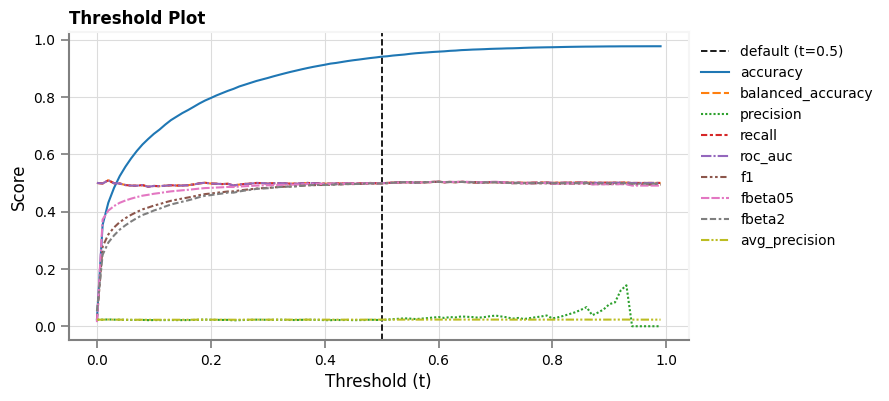

In [24]:
#| echo: true
vh.plot_multi_line_threshold_chart(
    df_thresholds_best_run.set_index("t"),
    ptitle_str="Threshold Plot",
    xlabel="Threshold (t)",
    ylabel="Score",
    title_fontsize=12,
    axis_label_fontsize=12,
    figsize=(8, 4),
)

::: {.callout-tip title="Observations"}

1. To be completed.
:::

## Get Size of Marketing Audience For Campaign

### Get Marketing Audience Using All Propensity Groups (Strategy 1)

Perform the following to get the sample size estimates for each audience propensity group, using this approach

1. Sort predictions in ascending order of the predicted probability (propensity) (`score`)
   - when predictions are then assigned to groups (bins), this order of sorting means the lowest group number will be assigned to samples (predictions) with the lowest probability, so this ordering is [non-standard](https://stackoverflow.com/questions/26496356/how-to-create-a-decile-and-quintile-columns-to-rank-another-variable-based-on-si/26502255#26502255)
   - the group integer-to-name mapping dictionary contains keys that start at the lowest group number (0) for the High propensity audience group
2. Separate the predictions into group, using the predicted probability, based on the required number of groups
3. Get conversion rates (KPI) per group
4. get sample sizes per group, based on
   - KPI per group
   - desired magnitude of the input (uplift, power, confidence level)
5. reverse order of groups and sort by group number
6. assign meaningful names to groups
7. set datatypes for columns
8. (optional) move column with meaningful names to second from front (for display purposes only)

In [25]:
#| echo: true
df_sample_sizes_strategy_1 = (
    df_prediction_best_run.copy()
    .pipe(ash.sort_scores, True)
    .pipe(ash.get_audience_groups_by_propensity, audience_groups_strategy_1["num_propens_groups"])
    .pipe(ash.get_kpi_per_audience_group)
    .pipe(
        ash.calculate_multi_group_sample_sizes,
        uplift_ranges,
        power_ranges,
        ci_level_ranges,
    )
    .pipe(ash.invert_group_numbers, audience_groups_strategy_1["num_propens_groups"])
    .pipe(ash.map_audience_group_number_to_name, mapper_dict_audience_strategy_1)
    .pipe(
        ash.set_datatypes,
        {
            "group_number": pd.Int8Dtype(),
            "maudience": pd.StringDtype(),
            "group_size": pd.Int16Dtype(),
            "group_min_propensity": pd.Float32Dtype(),
            "group_conv_rate": pd.Float32Dtype(),
            "uplift": pd.Int8Dtype(),
            "power": pd.Int8Dtype(),
            "ci_level": pd.Int8Dtype(),
            "required_sample_size": pd.Int32Dtype(),
        },
    ).pipe(ash.move_cols_to_front, ["group_number", "maudience"])
)
df_sample_sizes_strategy_1

Set all specified datatypes.


,group_number,maudience,group_size,group_min_propensity,group_conv_rate,uplift,power,ci_level,required_sample_size
0,0,High,6721,0.092311,2.157417,15,90,95,21180
1,0,High,6721,0.092311,2.157417,10,90,66,22586
2,0,High,6721,0.092311,2.157417,10,90,67,23003
3,0,High,6721,0.092311,2.157417,10,90,68,23430
4,0,High,6721,0.092311,2.157417,10,90,69,23869
...,...,...,...,...,...,...,...,...,...
1507,2,Low,6722,0.0,2.261232,15,55,67,2098
1508,2,Low,6722,0.0,2.261232,15,55,68,2205
1509,2,Low,6722,0.0,2.261232,15,55,69,2313
1510,2,Low,6722,0.0,2.261232,12,90,70,16097


### Get Marketing Audience Using Top Propensity Group (Strategy 2)

Perform the following to get the sample size estimates for the top audience propensity group, using this approach

1. Sort predictions in descending order of the predicted probability (propensity) (`score`)
2. get group (bin) size that separates the predictions into groups (bins) of equal size, using the predicted probability, based on the required number of groups
3. separate the predictions into groups, using the predicted probability, based on the
   - required number of groups
   - calculated group size from above step
4. get conversion rates (KPI) per group
5. get sample sizes per group, based on
   - KPI per group
   - desired magnitude of the input (uplift, power, confidence level)
6. subtract one from group number
7. assign meaningful names to groups
8. set datatypes for columns
9. (optional) move column with meaningful names to second from front (for display purposes only)

In [26]:
#| echo: true
df_sample_sizes_strategy_2 = (
    df_prediction_best_run.copy()
    .pipe(ash.sort_scores, False)
    .pipe(
        ash.calculate_single_group_sample_sizes,
        audience_groups_strategy_2["num_propens_groups"],
        ash.get_group_size(df_prediction_best_run, audience_groups_strategy_2["num_propens_groups"]),
        uplift_ranges,
        power_ranges,
        ci_level_ranges,
    )
    .pipe(ash.subtract_one_from_group_numbers, "group_number")
    .pipe(
        ash.map_audience_group_number_to_name,
        mapper_dict_audience_strategy_2,
        "group_number",
    )
    .pipe(
        ash.set_datatypes,
        {
            "group_number": pd.Int8Dtype(),
            "maudience": pd.StringDtype(),
            "group_size": pd.Int16Dtype(),
            "group_size_proportion": pd.Float32Dtype(),
            "group_min_propensity": pd.Float32Dtype(),
            "group_conv_rate": pd.Float32Dtype(),
            "uplift": pd.Int8Dtype(),
            "power": pd.Int8Dtype(),
            "ci_level": pd.Int8Dtype(),
            "required_sample_size": pd.Int32Dtype(),
        },
    )
    .pipe(ash.move_cols_to_front, ["group_number", "maudience"])
)
display(df_sample_sizes_strategy_2.dtypes.rename("dtype").to_frame().transpose())
df_sample_sizes_strategy_2

Set all specified datatypes.


,group_number,maudience,group_size,group_size_proportion,group_min_propensity,group_conv_rate,uplift,power,ci_level,required_sample_size
dtype,Int8,string[python],Int16,Float32,Float32,Float32,Int8,Int8,Int8,Int32


,group_number,maudience,group_size,group_size_proportion,group_min_propensity,group_conv_rate,uplift,power,ci_level,required_sample_size
0,0,High,6721,33.33168,0.092205,2.157417,10,55,55,2206
1,0,High,6721,33.33168,0.092205,2.157417,10,55,57,2644
2,0,High,6721,33.33168,0.092205,2.157417,10,55,60,3310
3,0,High,6721,33.33168,0.092205,2.157417,10,55,63,3995
4,0,High,6721,33.33168,0.092205,2.157417,10,55,65,4466
...,...,...,...,...,...,...,...,...,...,...
1507,2,High-Medium-Low,20163,99.995041,0.0,2.306204,15,90,70,10097
1508,2,High-Medium-Low,20163,99.995041,0.0,2.306204,15,90,75,11126
1509,2,High-Medium-Low,20163,99.995041,0.0,2.306204,15,90,85,13940
1510,2,High-Medium-Low,20163,99.995041,0.0,2.306204,15,90,90,16124


## Export Audience Sample Sizes to Disk

Concatenate the two `DataFrame`s with the required sample sizes to acheive a KPI using different combinations of inputs (uplift, confidence level and power) and then export to disk

In [27]:
#| echo: true
#| output: false
(
    df_combined_sample_sizes,
    aud_sizes_fpath,
) = ash.combine_and_export_sample_size_estimates(
    df_sample_sizes_strategy_1,
    df_sample_sizes_strategy_2,
    df_deployment_candidate_mlflow_models,
    processed_data_dir,
)

Exported 3,024 rows and 11 columns of sample size estimates, using both (a) all visitors and (b) only high-propensity visitors, to audience_sample_sizes__run_742cf152d5094be0b686edf910c7d398.parquet.gzip


::: {.content-hidden}
Get summary of sample size `DataFrame`
:::

In [28]:
#| output: false
display(df_combined_sample_sizes.dtypes.rename("dtype").to_frame())
display(df_combined_sample_sizes)

,dtype
group_number,Int8
maudience,string[python]
group_size,Int32
group_min_propensity,Float32
group_conv_rate,Float32
uplift,Int8
power,Int8
ci_level,Int8
required_sample_size,Int32
audience_strategy,Int8


,group_number,maudience,group_size,group_min_propensity,group_conv_rate,uplift,power,ci_level,required_sample_size,audience_strategy,group_size_proportion
0,0,High,6721,0.092311,2.157417,15,90,95,21180,1,<NA>
1,0,High,6721,0.092311,2.157417,10,90,66,22586,1,<NA>
2,0,High,6721,0.092311,2.157417,10,90,67,23003,1,<NA>
3,0,High,6721,0.092311,2.157417,10,90,68,23430,1,<NA>
4,0,High,6721,0.092311,2.157417,10,90,69,23869,1,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
3019,2,High-Medium-Low,20163,0.0,2.306204,15,90,70,10097,2,99.995041
3020,2,High-Medium-Low,20163,0.0,2.306204,15,90,75,11126,2,99.995041
3021,2,High-Medium-Low,20163,0.0,2.306204,15,90,85,13940,2,99.995041
3022,2,High-Medium-Low,20163,0.0,2.306204,15,90,90,16124,2,99.995041


## ML Experiment Tracking

Get best run ID

In [29]:
#| echo: true
best_run_id = df_deployment_candidate_mlflow_models.squeeze()["run_id"]

Log audience sample sizes file as MLFlow artifact

In [30]:
#| echo: true
#| output: false
with mlflow.start_run(run_id=best_run_id) as run:
    mlflow.log_artifact(aud_sizes_fpath)
print(
    "Logged required audience sizes as artifact in file "
    f"{os.path.basename(aud_sizes_fpath)}"
)

Logged required audience sizes as artifact in file audience_sample_sizes__run_742cf152d5094be0b686edf910c7d398.parquet.gzip


## Next Step

Next, test and control cohorts will be created using the inference data at the end of the production period (one month). The size of each cohort will be chosen based on the required sizes that were found in this step.